
## Animal Faces classification
This dataset, also known as Animal Faces-HQ (AFHQ), consists of 16,130 high-quality images at 512×512 resolution. 
Url of the dataset : https://www.kaggle.com/andrewmvd/animal-faces

Dataset description :
- number of images : 16,130
- Training size : 14630 images 
- they are 3 categories(classes) in this dataset (cat, dog, wild)
- val set size :1500 images  (cat, dog, wild)

- Image size : 512*512 pixels

In [1]:
#  loading required Librairies

import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

### animal-faces dataset
The dataset is extracted to the directory animal-faces. It contains 2 folders (train and val), containing the training set  (14630 images) with 3 classes and val set (14630) with 3 classes respectively.

In [2]:
# Import dataset

data_dir = '../input/animal-faces/afhq'
print('Folders :', os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print('3 classes :', classes)

Folders : ['val', 'train']
3 classes : ['dog', 'cat', 'wild']


In [3]:
dataset = ImageFolder(data_dir + '/train', transform=ToTensor())
print('Size of training Dataset :', len(dataset))

Size of training Dataset : 14630


In [4]:
val_ds = ImageFolder(data_dir + '/val', transform=ToTensor())
print('Size of val Dataset :', len(val_ds))

Size of val Dataset : 1500


Each element from the training dataset is a tuple, containing a image tensor and a label. Since the data consists of 512x512 pixel color images with 3 channels (RGB), each image tensor has the shape (3, 512, 512) :

In [5]:
img, label = dataset[0]
print(img.shape)

torch.Size([3, 512, 512])


Display of an image and its label using matplotlib :

Label:  cat (0)


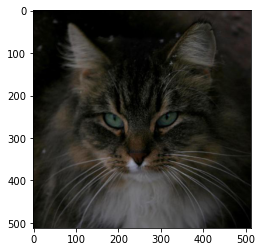

In [6]:
def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))
    
show_example(*dataset[0])

Label:  wild (2)


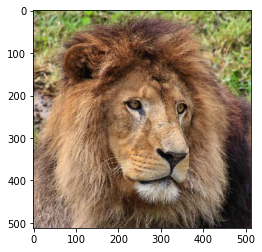

In [9]:
show_example(*dataset[13879])

### Preparing the data for training
The dataset is split into 3 parts :
- Training set : used to train the model i.e. compute the loss and adjust the weights of the model using gradient descent ;
- Validation set : used to evaluate the model while training, adjust hyperparameters (learning rate etc.) and pick the best version of the model ;
- Test set : used to compare different models, or different types of modeling approaches, and report the final accuracy of the model.
Since there's no predefined test set, we can set aside a small portion (5000 images) to be used as the test set. We'll use the random_split helper method from PyTorch to do this. To ensure that we always create the same test set, we'll also set a seed for the random number generator :

In [10]:
torch.manual_seed(43)
test_size = 5000
train_size = len(dataset) - test_size

In [11]:
train_ds, test = random_split(dataset, [train_size, test_size])
len(train_ds), len(test)

(9630, 5000)

We can now create data loaders for training and validation, to load the data in batches

In [12]:
batch_size = 15
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_loader = DataLoader(test, batch_size*2, num_workers=4, pin_memory=True)

We can look at batches of images from the dataset using the make_grid method from torchvision. Each time the following code is run, we get a different bach, since the sampler shuffles the indices before creating batches :

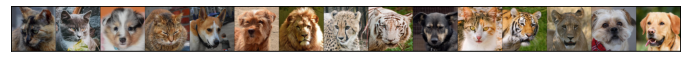

In [13]:
for images, labels in train_loader:
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
    break

###  MY APPROACH: FEEDFORWARD NN


In [14]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [15]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [16]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

Cheking if the GPU is available so we can move data into:

In [17]:
torch.cuda.is_available()

True

In [18]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [19]:
device = get_default_device()
device

device(type='cuda')

In [27]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [28]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

### Training the Model:


In [23]:
input_size = 3*512*512 # INPUT SIZE
output_size = 3 # Number of classes

In [24]:
class Model(ImageClassificationBase):
    def __init__(self, input_size, output_size):
        super().__init__()
        # hidden layer
        self.in_layer = nn.Linear(input_size, 64)
        self.hidden1 = nn.Linear(64, 256)
        self.hidden2 = nn.Linear(256, 512)
        self.hidden3 = nn.Linear(512, 1048)
        self.out_layer = nn.Linear(1048, output_size)
        
    def forward(self, xb):
        # Flatten images into vectors
        out = xb.view(xb.size(0), -1)
        # Apply layers & activation functions
        # Input layer
        out = self.in_layer(out)
        # Hidden layers w/ ReLU
        out = self.hidden1(F.relu(out))
        out = self.hidden2(F.relu(out))
        out = self.hidden3(F.relu(out))
        # Class output layer
        out = self.out_layer(F.relu(out))
        return out

In [25]:
model = to_device(Model(input_size, output_size), device)

In [29]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 1.098657250404358, 'val_acc': 0.3333333730697632}]

we are having a accuracy of 33.3% before the model is trained

we gonna train the model and see if there is some improvements

We train the model using the fit function to reduce the validation loss & improve accuracy :

In [30]:
history += fit(4, 0.0001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.0847, val_acc: 0.3453
Epoch [1], val_loss: 1.0658, val_acc: 0.4153
Epoch [2], val_loss: 1.0370, val_acc: 0.5327
Epoch [3], val_loss: 0.9974, val_acc: 0.5820


In [31]:
history += fit(3, 0.00001, model, train_loader, val_loader)

Epoch [0], val_loss: 0.9871, val_acc: 0.5913
Epoch [1], val_loss: 0.9823, val_acc: 0.5893
Epoch [2], val_loss: 0.9761, val_acc: 0.6073


It seems like 0.0001 is a good learning rate so we better keep it this way

After 6 epoch we're getting a accuracy of 60% ,

In [32]:
history += fit(2, 0.0001, model, train_loader, val_loader)

Epoch [0], val_loss: 0.9178, val_acc: 0.6300
Epoch [1], val_loss: 0.8570, val_acc: 0.6560


In [33]:
history += fit(3, 0.0001, model, train_loader, val_loader)

Epoch [0], val_loss: 0.8064, val_acc: 0.6813
Epoch [1], val_loss: 0.7672, val_acc: 0.6853
Epoch [2], val_loss: 0.7424, val_acc: 0.6773


let change the learning late to 0.0005 and see if we could get some changes:

In [34]:
history += fit(3, 0.0005, model, train_loader, val_loader)

Epoch [0], val_loss: 0.7061, val_acc: 0.6967
Epoch [1], val_loss: 0.6240, val_acc: 0.7387
Epoch [2], val_loss: 0.6650, val_acc: 0.7193


 Incrementing the learning late by a little value seem to work good now lets move to 0.0007 and see if we could get some changes:

In [36]:
history += fit(3, 0.0007, model, train_loader, val_loader)

Epoch [0], val_loss: 0.5388, val_acc: 0.7727
Epoch [1], val_loss: 0.5261, val_acc: 0.7900
Epoch [2], val_loss: 0.5353, val_acc: 0.7840


In [37]:
history += fit(3, 0.0009, model, train_loader, val_loader)

Epoch [0], val_loss: 0.4925, val_acc: 0.8060
Epoch [1], val_loss: 0.6039, val_acc: 0.7607
Epoch [2], val_loss: 0.5965, val_acc: 0.7607


In [38]:
history += fit(3, 0.0005, model, train_loader, val_loader)

Epoch [0], val_loss: 0.4707, val_acc: 0.8147
Epoch [1], val_loss: 0.5148, val_acc: 0.8007
Epoch [2], val_loss: 0.4653, val_acc: 0.8153


In [39]:
history += fit(3, 0.00007, model, train_loader, val_loader)

Epoch [0], val_loss: 0.4491, val_acc: 0.8367
Epoch [1], val_loss: 0.4572, val_acc: 0.8267
Epoch [2], val_loss: 0.4442, val_acc: 0.8353


In [40]:
history += fit(2, 0.0001, model, train_loader, val_loader)

Epoch [0], val_loss: 0.4463, val_acc: 0.8307
Epoch [1], val_loss: 0.4660, val_acc: 0.8180


If you want you can continue adjusting this model and see if you can get better result  approach and see if we could get better result.
Here we are getting 81% and its good! 

### Evaluating the model
We plot of the losses & accuracies and evaluate the first model on the test set :

In [41]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

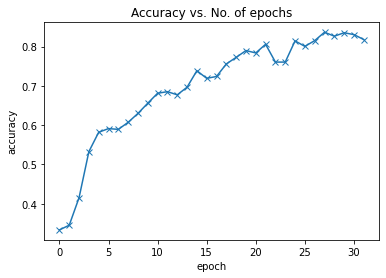

In [42]:
plot_accuracies(history)

As you can see on the chart the accuracy on 81%-85% started to be stable

In [43]:
def plot_losses(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs');

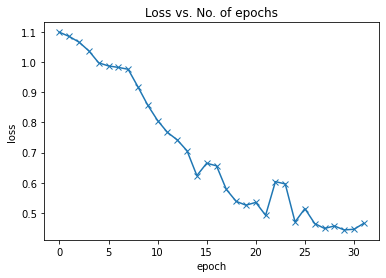

In [44]:
plot_losses(history)

loss reduced dramatically and started to get stable.

In [45]:
evaluate(model, test_loader)

{'val_loss': 0.49072131514549255, 'val_acc': 0.8134729266166687}

In [47]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Label: dog , Predicted: dog


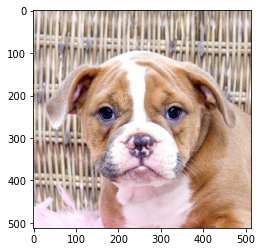

In [48]:
img, label = test[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: wild , Predicted: wild


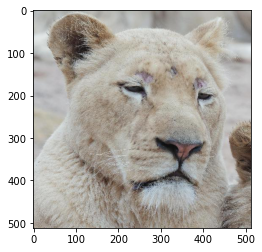

In [51]:
img, label = test[789]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: wild , Predicted: wild


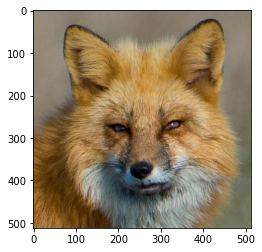

In [67]:
img, label = test[2890]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: cat , Predicted: cat


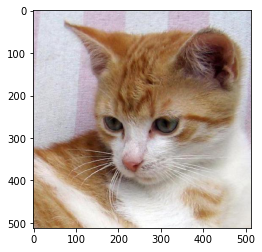

In [52]:
img, label = test[100]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: dog , Predicted: dog


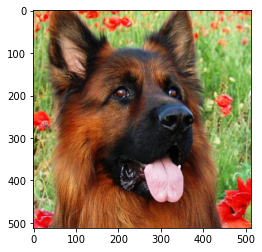

In [57]:
img, label = test[490]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

# for an accuracy of 81.3% our model is very efficient, it could predict any animal from the dataset

# conclusion

We get a prediction rate of 81.3%, knowing that there are 3 classes to predict, which is a good score.

-you can use CNN in the future to see if it could bring better result ,
-and the training step took a lot of time probably due to the image pixels(512px), which was huge to fit in the memory


In [46]:
!pip install jovian --upgrade --quiet

In [53]:
import jovian

<IPython.core.display.Javascript object>

In [54]:
project_name = "NN animal faces classification "

In [ ]:
jovian.commit(project=project_name, environment=None, outputs=['animal face classf.pth'])

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Please enter your API key ( from https://jovian.ml/ ):
API KEY: ········
[jovian] Uploading notebook to https://jovian.ml/tonnyshm/NN animal faces classification 


<IPython.core.display.Javascript object>